In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score,confusion_matrix,classification_report,roc_auc_score)
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv("credit_risk_dataset.csv")
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
person_age                    32581 non-null int64
person_income                 32581 non-null int64
person_home_ownership         32581 non-null object
person_emp_length             31686 non-null float64
loan_intent                   32581 non-null object
loan_grade                    32581 non-null object
loan_amnt                     32581 non-null int64
loan_int_rate                 29465 non-null float64
loan_status                   32581 non-null int64
loan_percent_income           32581 non-null float64
cb_person_default_on_file     32581 non-null object
cb_person_cred_hist_length    32581 non-null int64
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [5]:
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

In [6]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [7]:
df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       32581.000000  32581.000000   
mean      27.734600   6.607485e+04           4.767994   9589.371106   
std        6.348078   6.198312e+04           4.087372   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   32581.000000  32581.000000         32581.000000   
mean       11.009620      0.218164             0.170203   
std         3.081611      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         8.490000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.110000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

In [8]:
df['loan_status'].value_counts(normalize=True) * 100

0    78.183604
1    21.816396
Name: loan_status, dtype: float64

In [9]:
df['loan_status'].unique()

array([1, 0], dtype=int64)

In [10]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('loan_status')

num_cols


Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

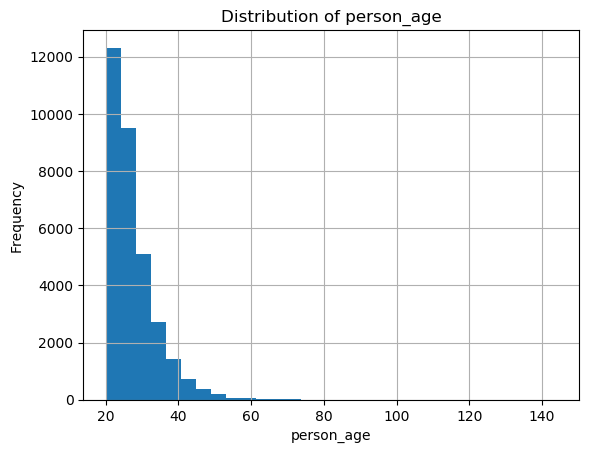

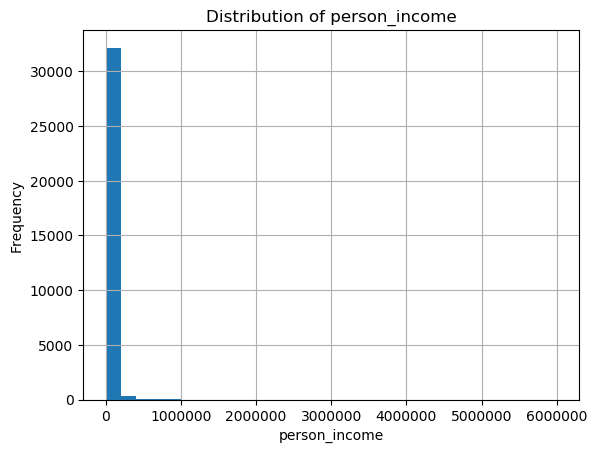

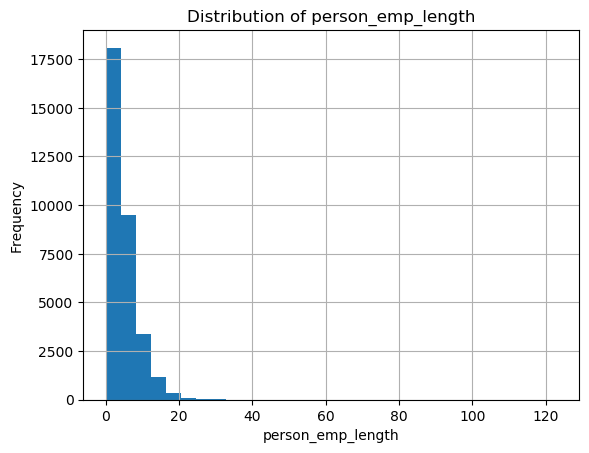

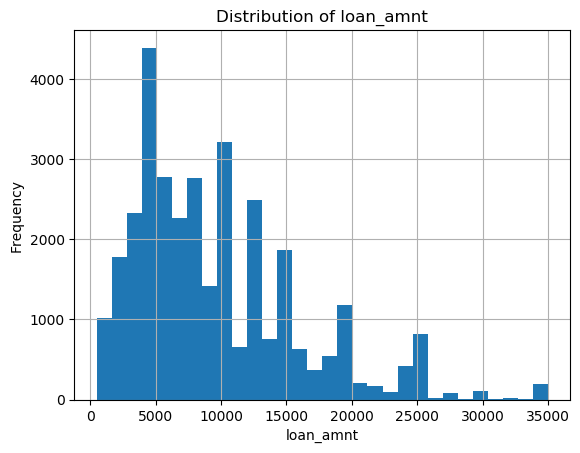

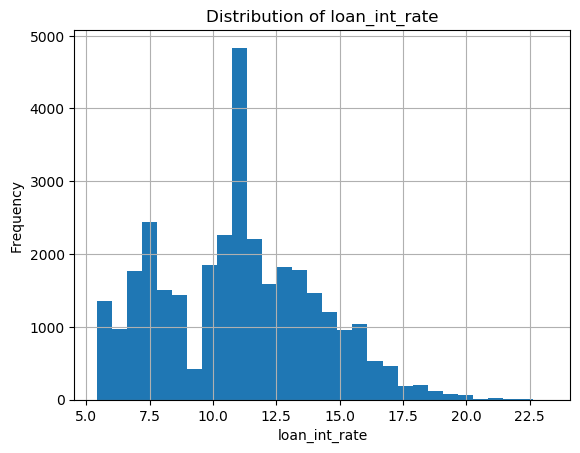

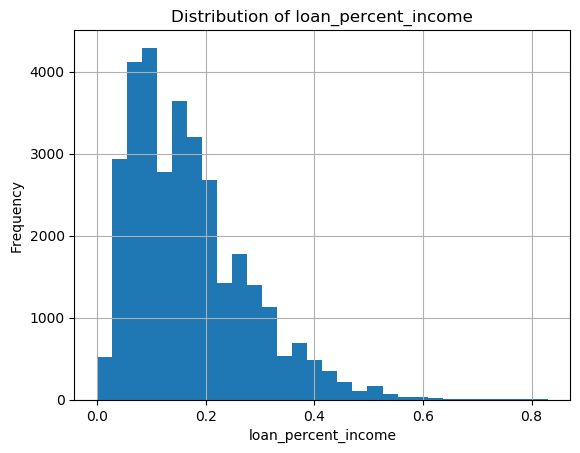

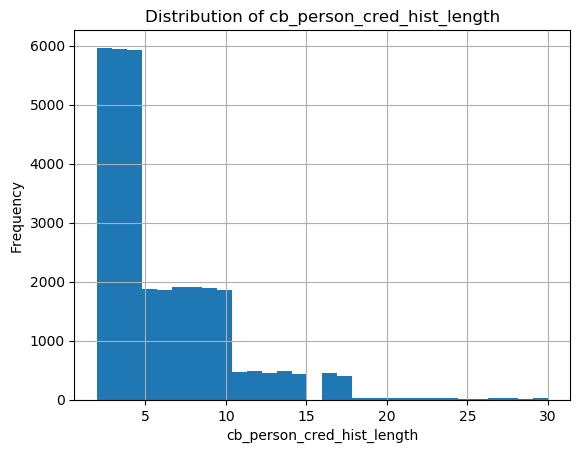

In [11]:
import matplotlib.pyplot as plt

for col in num_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


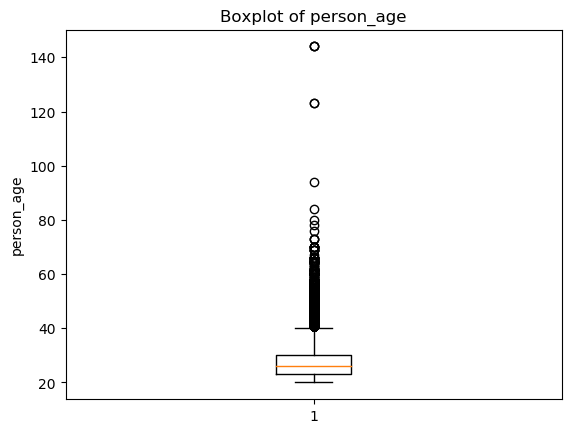

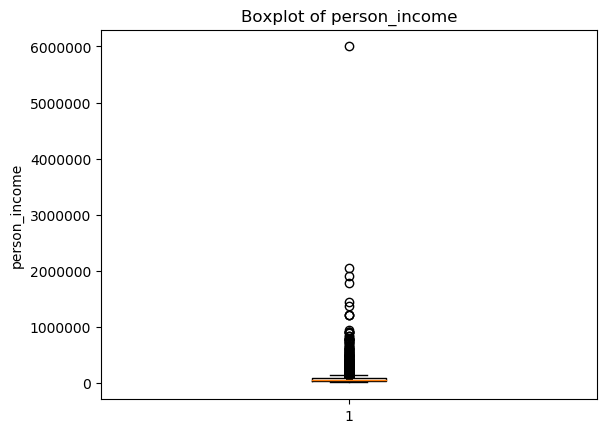

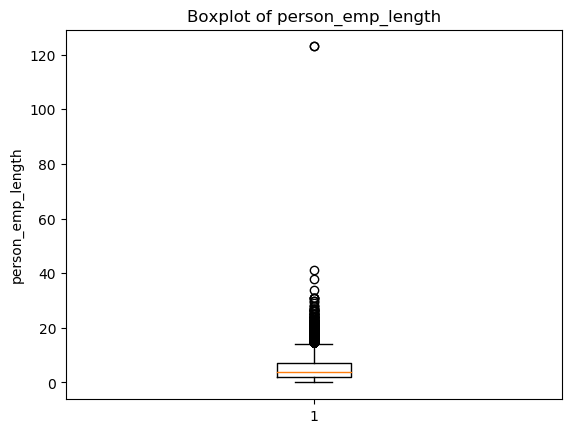

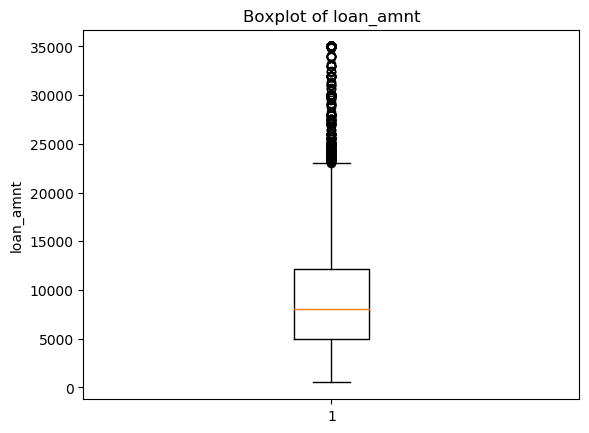

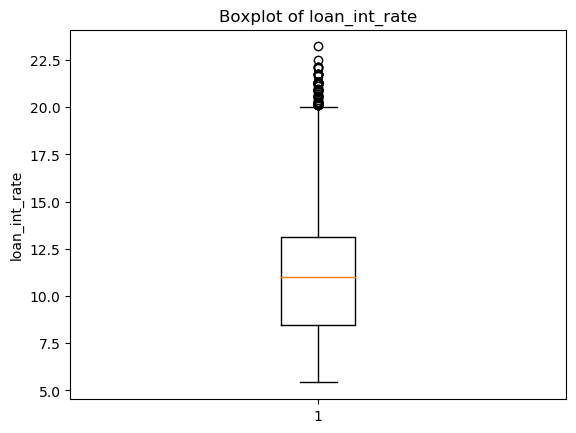

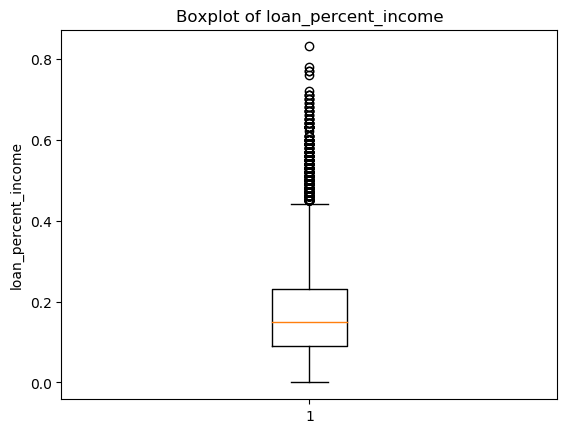

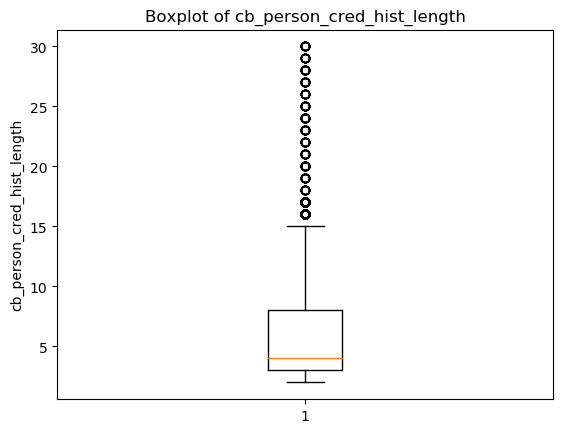

In [12]:
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()


In [13]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

for col in num_cols:
    cap_outliers(df, col)


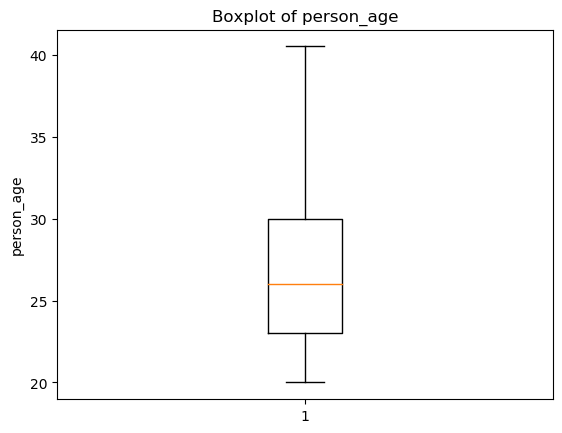

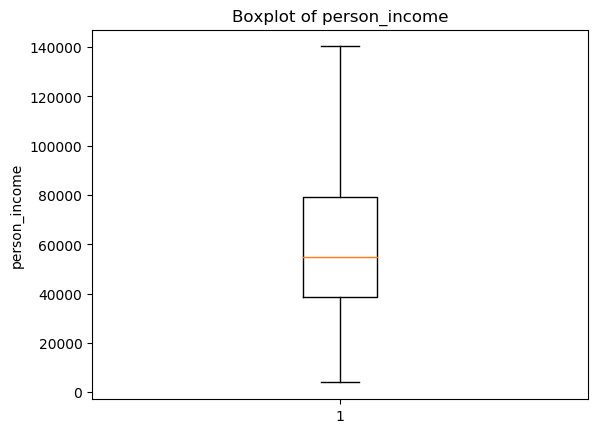

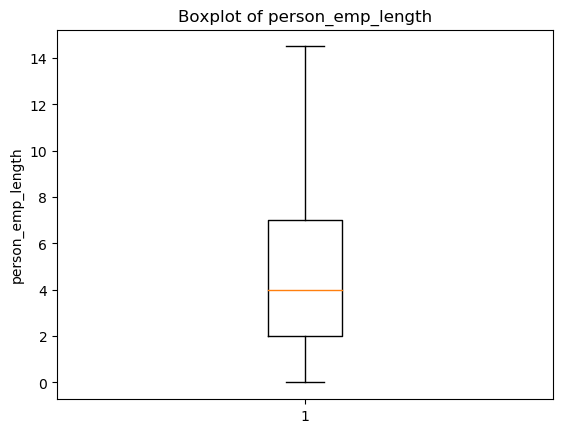

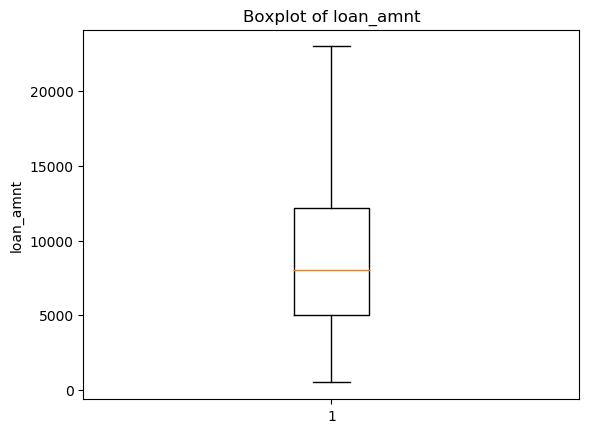

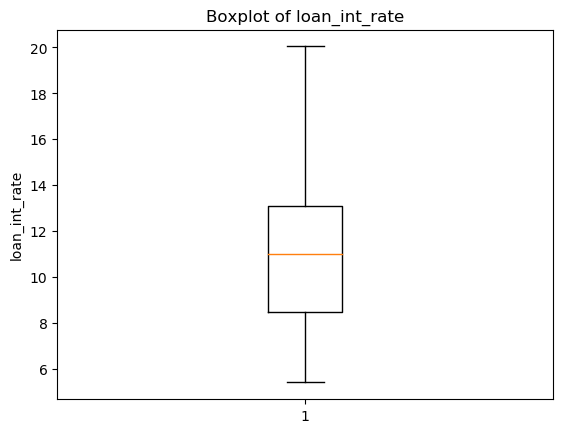

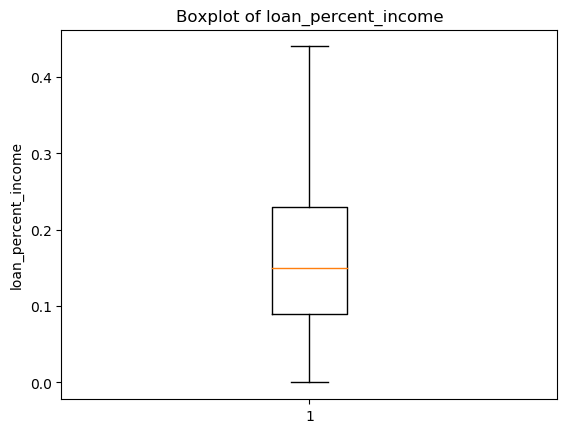

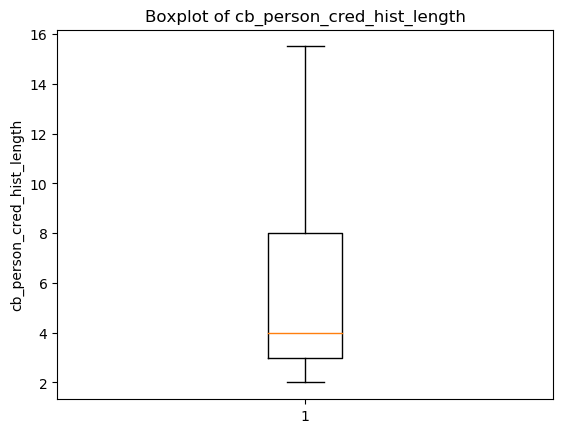

In [14]:
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()


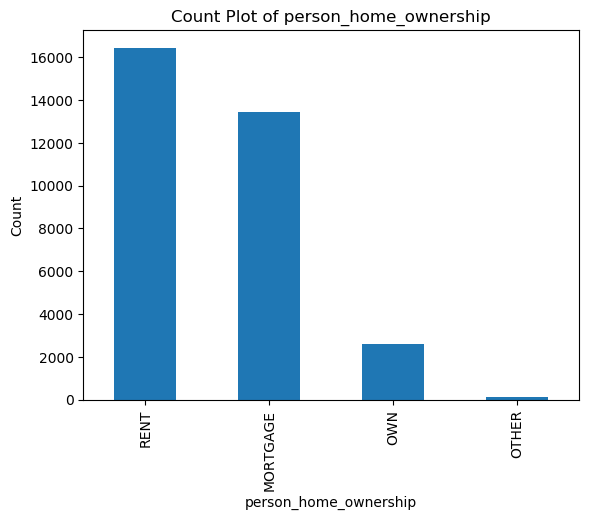

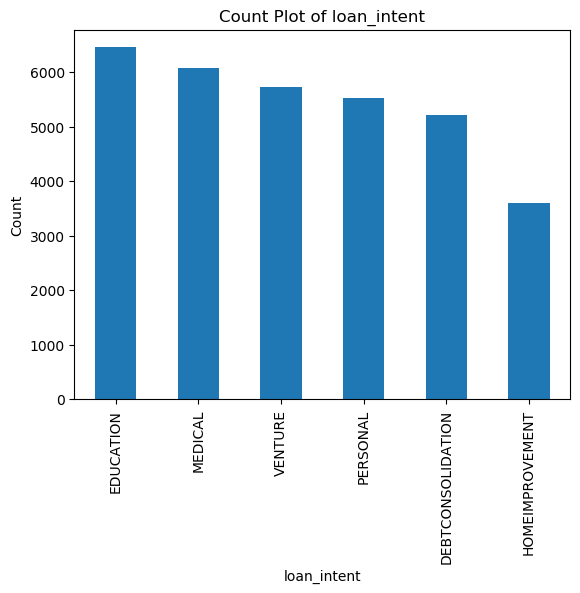

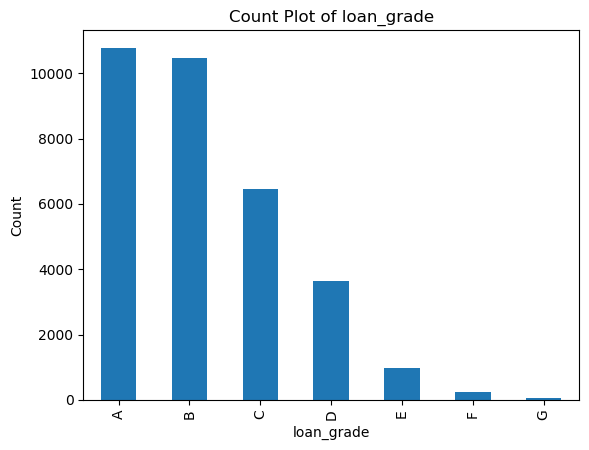

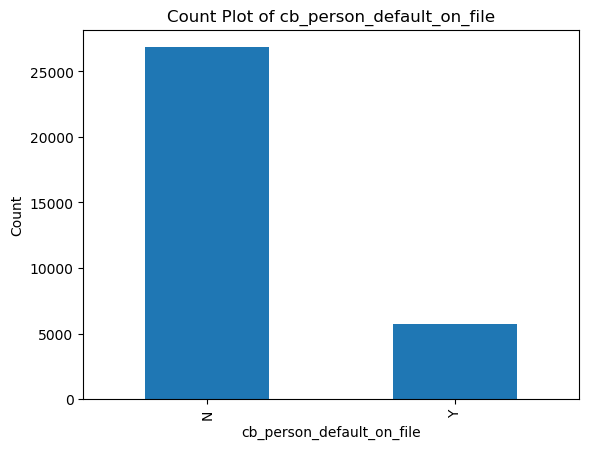

In [15]:
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure()
    df[col].value_counts().plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Count Plot of {col}')
    plt.show()



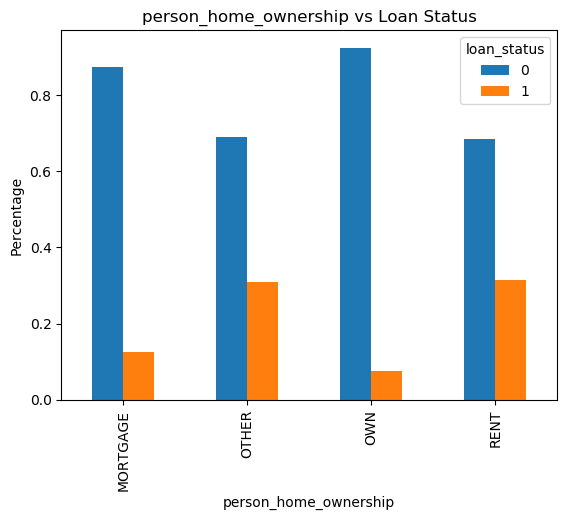

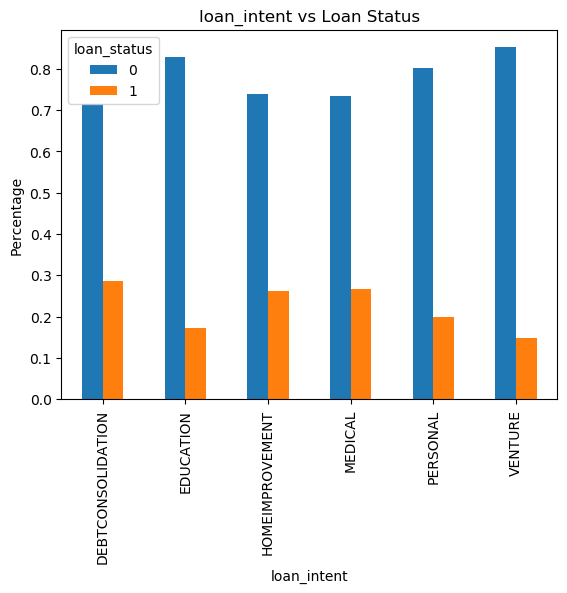

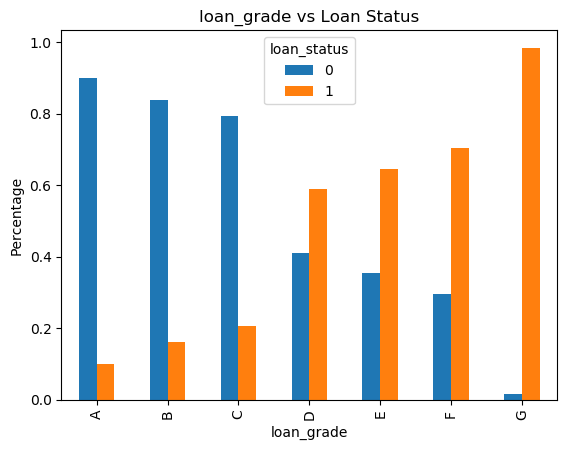

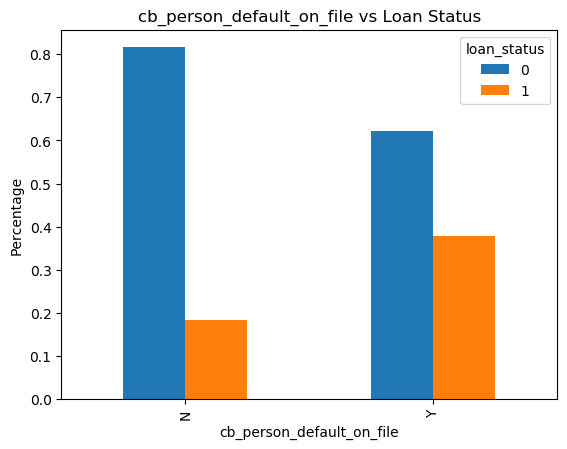

In [16]:
for col in cat_cols:
    pd.crosstab(df[col], df['loan_status'], normalize='index').plot(kind='bar')
    plt.title(f'{col} vs Loan Status')
    plt.ylabel('Percentage')
    plt.xlabel(col)
    plt.show()



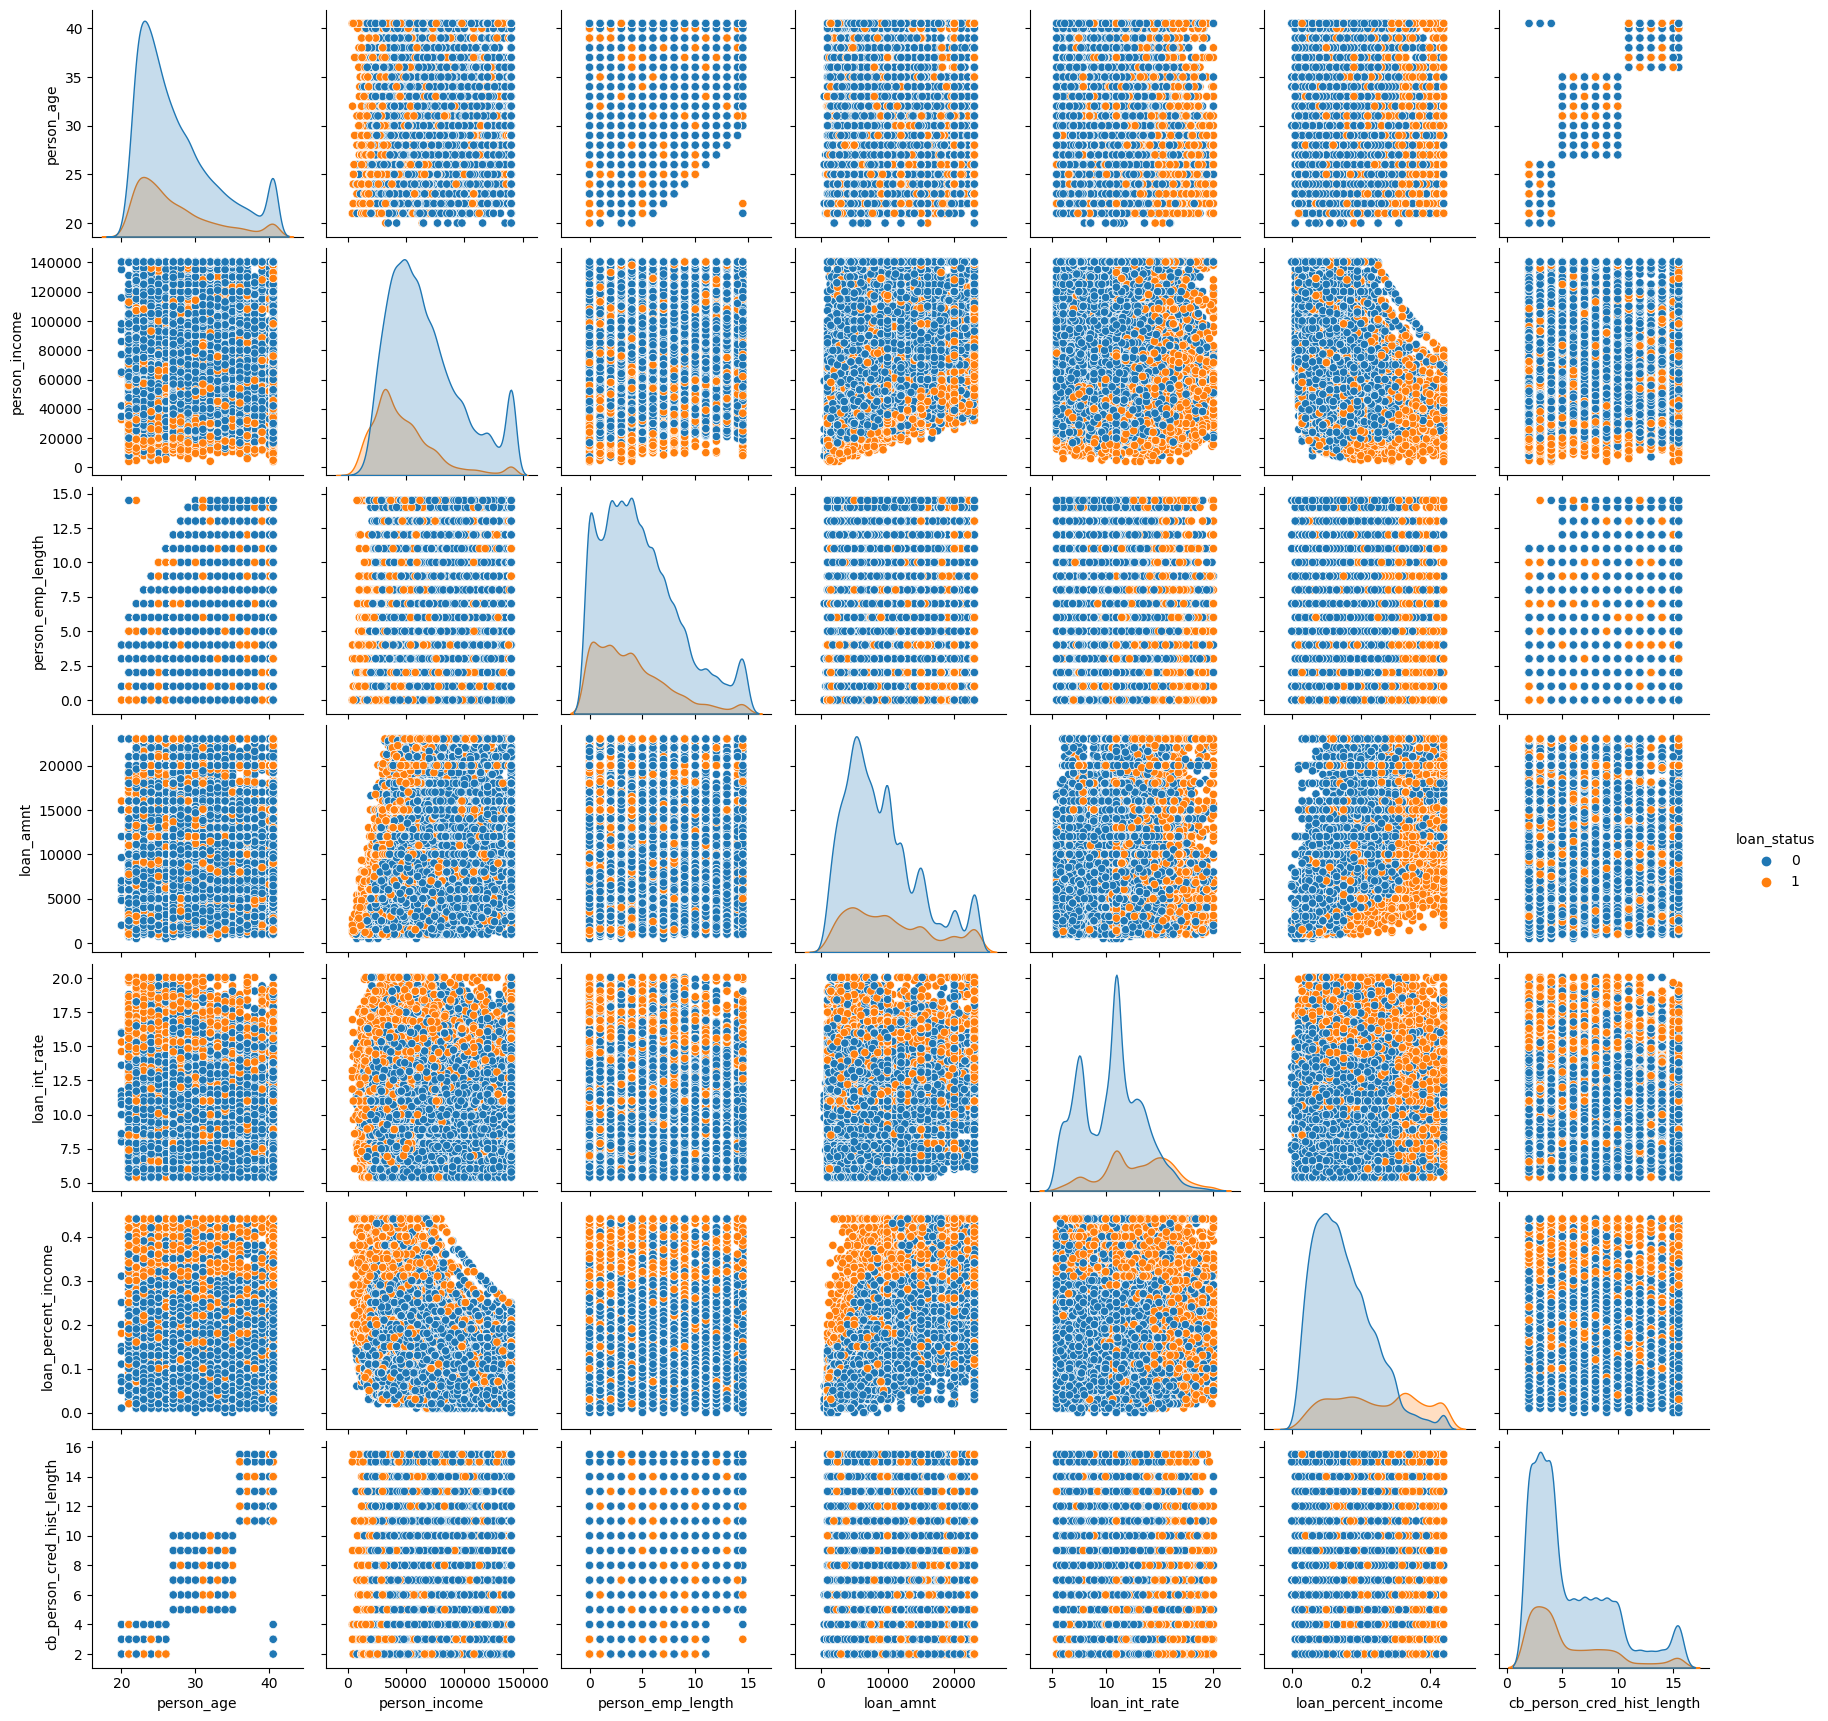

In [17]:
sns.pairplot(df,hue="loan_status")

In [18]:
df = df.drop(df[df['person_age'] > 80].index, axis=0)
#dropping age above 80

In [19]:
df['age_group'] = pd.cut(df['person_age'],
                           bins=[20, 26, 36, 46, 56, 66],
                           labels=['20-25', '26-35', '36-45', '46-55', '56-65'])

In [20]:
df['age_group'].dtype

CategoricalDtype(categories=['20-25', '26-35', '36-45', '46-55', '56-65'], ordered=True)

In [21]:
df['income_group'] = pd.cut(df['person_income'],
                              bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                              labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

In [22]:
df['loan_amount_group'] = pd.cut(df['loan_amnt'],
                                   bins=[0, 5000, 10000, 15000, float('inf')],
                                   labels=['small', 'medium', 'large', 'very large'])

In [23]:
df = df.drop(df[df['person_emp_length'] > 60].index, axis=0)

In [24]:
# Create loan-to-income ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

# Create loan-to-employment length ratio
df['loan_to_emp_length_ratio'] =  df['person_emp_length']/ df['loan_amnt'] 

# Create interest rate-to-loan amount ratio
df['int_rate_to_loan_amt_ratio'] = df['loan_int_rate'] / df['loan_amnt']

In [25]:
X = df.drop(['loan_status'], axis=1)
Y = df['loan_status']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=12,
    stratify=Y
)

In [27]:
print(x_train.shape,x_test.shape)

(26064, 17) (6517, 17)


In [28]:
x_train.reset_index(inplace = True)
x_test.reset_index(inplace = True)

In [29]:
x_train.select_dtypes(include='object').columns


Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [30]:
cat_cols = x_train.select_dtypes(include=['object', 'category']).columns

freq_encoding_maps = {}

for col in cat_cols:
    freq_encoding_maps[col] = x_train[col].value_counts().to_dict()
    x_train[col] = x_train[col].astype(str).map(freq_encoding_maps[col])
    x_test[col] = x_test[col].astype(str).map(freq_encoding_maps[col]).fillna(0)


C:\Users\khavy\anaconda3\envs\aiml\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\khavy\anaconda3\envs\aiml\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
C:\Users\khavy\anaconda3\envs\aiml\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [31]:
x_train = x_train.copy()
x_test = x_test.copy()

num_cols = x_train.select_dtypes(include=['int64','float64']).columns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])


In [32]:
x_train.dtypes

index                         float64
person_age                    float64
person_income                 float64
person_home_ownership         float64
person_emp_length             float64
loan_intent                   float64
loan_grade                    float64
loan_amnt                     float64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file     float64
cb_person_cred_hist_length    float64
age_group                     float64
income_group                  float64
loan_amount_group             float64
loan_to_income_ratio          float64
loan_to_emp_length_ratio      float64
int_rate_to_loan_amt_ratio    float64
dtype: object

In [33]:
# # Fill missing numeric values with 0
# x_train = x_train.fillna(0)
# x_test = x_test.fillna(0)


In [34]:
y_train.value_counts()
y_test.value_counts()


0    5095
1    1422
Name: loan_status, dtype: int64

In [35]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr.fit(x_train, y_train)

lr_pred = lr.predict(x_test)
lr_prob = lr.predict_proba(x_test)[:, 1]

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("F1 (weighted):", f1_score(y_test, lr_pred, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, lr_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))
print("Classification Report:\n", classification_report(y_test, lr_pred))


Logistic Regression
Accuracy: 0.7977597053859138
F1 (weighted): 0.8103649923372623
ROC-AUC: 0.8681687874132687
Confusion Matrix:
 [[4082 1013]
 [ 305 1117]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      5095
           1       0.52      0.79      0.63      1422

    accuracy                           0.80      6517
   macro avg       0.73      0.79      0.74      6517
weighted avg       0.84      0.80      0.81      6517



In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

dt.fit(x_train, y_train)

dt_pred = dt.predict(x_test)
dt_prob = dt.predict_proba(x_test)[:, 1]

print("Decision Tree")
print("F1 (weighted):", f1_score(y_test, dt_pred, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, dt_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("Classification Report:\n", classification_report(y_test, dt_pred))


Decision Tree
F1 (weighted): 0.8892599189699504
ROC-AUC: 0.8909248194294342
Confusion Matrix:
 [[4708  387]
 [ 339 1083]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      5095
           1       0.74      0.76      0.75      1422

    accuracy                           0.89      6517
   macro avg       0.83      0.84      0.84      6517
weighted avg       0.89      0.89      0.89      6517



In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(x_train, y_train)

rf_pred = rf.predict(x_test)
rf_prob = rf.predict_proba(x_test)[:, 1]

print("Random Forest")
print("F1 (weighted):", f1_score(y_test, rf_pred, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))


Random Forest
F1 (weighted): 0.8991995128245613
ROC-AUC: 0.9164138747758828
Confusion Matrix:
 [[4766  329]
 [ 328 1094]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      5095
           1       0.77      0.77      0.77      1422

    accuracy                           0.90      6517
   macro avg       0.85      0.85      0.85      6517
weighted avg       0.90      0.90      0.90      6517



In [38]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='logloss',
    random_state=42
)

xgb.fit(x_train, y_train)

xgb_pred = xgb.predict(x_test)
xgb_prob = xgb.predict_proba(x_test)[:, 1]

print("XGBoost")
print("F1 (weighted):", f1_score(y_test, xgb_pred, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, xgb_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))


XGBoost
F1 (weighted): 0.9312060548834865
ROC-AUC: 0.9605996612878516
Confusion Matrix:
 [[4910  185]
 [ 259 1163]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      5095
           1       0.86      0.82      0.84      1422

    accuracy                           0.93      6517
   macro avg       0.91      0.89      0.90      6517
weighted avg       0.93      0.93      0.93      6517



In [39]:
xgb.feature_names_in_


array(['index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'age_group', 'income_group', 'loan_amount_group',
       'loan_to_income_ratio', 'loan_to_emp_length_ratio',
       'int_rate_to_loan_amt_ratio'], dtype='<U26')

In [41]:
import pickle

artifact = {
    'model': xgb,
    'scaler': scaler,
    'freq_encoding_maps': freq_encoding_maps,
    'feature_names': xgb.feature_names_in_
}

pickle.dump(artifact, open('credit_risk_artifacts.csv', 'wb'))

